## CIR Model to simulate Changes in Interest Rates and Liability Hedging
The Cox Ingersoll Ross Model used to model the dynamics of interest rates, and is an extension of the popular Vasicek model to prevent negative interest rates

$$dr_t=a(b-r_t)dt+\sigma\sqrt[]{r_t}dW_t$$

$dr_t$ = small changes in interest rates

$(b-rt)$ = interest today - long term mean() for interest rate

$a$ = how fast revert to r_t, mean reverse speed

$b$ = long term mean interest()

In [1]:
import numpy as np
import pandas as pd
import risk_kit as erk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

## Short Rate vs Annualized

In [3]:
#ir = 100%
#time = 1 year
1 + 1*1

2

In general , if we compound every 1/N a year (i.e. N times a year) we get:

$$\left(i+\frac{r}{N}\right)^N$$
    

In [4]:
# 2 times a year
(1+1/2)**2

2.25

In [5]:
# 4 times a year
(1+1/4)**4

2.44140625

In [6]:
# 1000000 times a year
(1+1/1000000)**1000000

2.7182804690957534

As N becomes very large we get the generalization:


$$1+r_{annual} = e^{r_{inst}}$$

i.e:

$$r_{annual} = e^{r_{inst}}-1$$

and

$$r_{inst}= ln(1+r_{annual})$$

In [7]:
def inst_to_ann(r):
    """
    Converts short rate to ann rate
    """
    return np.expm1(r)
def ann_to_inst(r):
    """
    Converts ann rate to short rate 
    """
    return np.log1p(r)

In [8]:
def ann_to_inst(r):
    """
    Converts ann rate to short rate 
    """
    return np.log1p(r)

### returning to the equation

$$dr_t=a(b-r_t)dt+\sigma\sqrt[]{r_t}dW_t$$


In [9]:
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    """
    Implements the CIR model for interest rates
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    #random numbers dWt
    num_steps = int(n_years*steps_per_year)+1
    shock = np.random.normal(0, scale= np.sqrt(dt), size = (num_steps, n_scenarios))
    
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    #simulating changes in rates
    for step in range(1, num_steps):
        r_t = rates[step-1]
        
        d_r_t = a*(b-r_t)*dt+ sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        
    return pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))
        
    
    
            

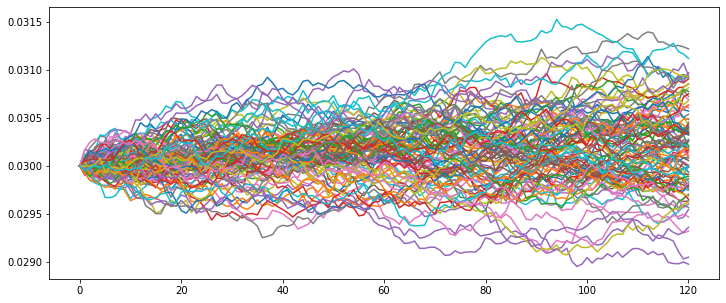

In [10]:
cir(n_scenarios = 100, sigma = 0.001).plot(figsize = (12,5), legend = False)

### Playing with Widgets

In [11]:
def show_cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12):
    b_0 = b
    rcir = cir(n_years = n_years, n_scenarios = n_scenarios, a = a, b = b, sigma = sigma, steps_per_year = steps_per_year)
    ax = rcir.plot(legend = False, color = 'indianred', alpha = 0.5, linewidth = 2, figsize = (12,5))
    ax.axhline(y=b_0, color = 'black', alpha = 0.5)
    

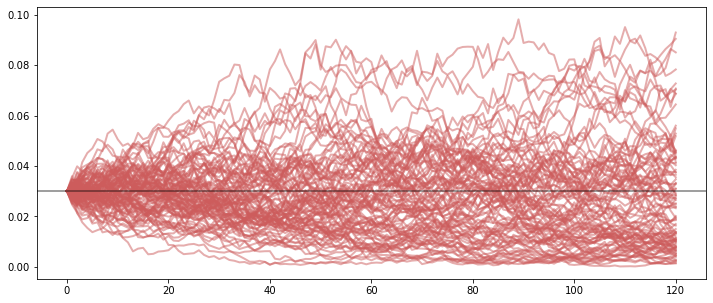

In [12]:
show_cir(n_scenarios = 100)

In [13]:
import ipywidgets as widgets
from IPython.display import display

In [14]:
cir_controls = widgets.interactive(show_cir,
                                   n_years = (1,10,1),
                                   n_scenarios= (1,100,1),
                                   a = (0,0.1,0.01),
                                   b = (0,0.1,0.01),
                                   sigma = (0,0.3,0.01), steps_per_year = (1,12,1) )                            

In [15]:
display(cir_controls)

interactive(children=(IntSlider(value=10, description='n_years', max=10, min=1), IntSlider(value=1, descriptio…

The Model also be used to generate the mobement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:
$$P(t,T)=A(t,T)e^{B(t,T)r_t}$$
where:
$$A(t,T)=(\frac{2he^{(a+h)*t/2}}{2h + (a+h)(e^th-1)})^{2ab/e^2}$$

and
$$B(t,T)=(\frac{2(e^th-1)}{2h + (a+h)(e^th-1)})$$
and
$$h=\sqrt[]{a^2+2\sigma^2} $$
and
$$ t= T-t $$


In [16]:
import math
def cir(n_years = 10, n_scenarios = 1, a = 0.05, b = 0.03, sigma = 0.05, steps_per_year = 12, r_0 = None):
    """
    Generates random interest rate evolution over time usin the CIR model
    b and r_0 are assumed to be the annualized rates, not the short rate
    and the returned values are the annualized rates as well
    """
    if r_0 is None:
        r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    #random numbers dWt
    num_steps = int(n_years*steps_per_year)+1
    
    shock = np.random.normal(0, scale= np.sqrt(dt), size = (num_steps, n_scenarios))
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    #for price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h+(h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    
    
    #simulating changes in rates
    for step in range(1, num_steps):
        r_t = rates[step-1]        
        d_r_t = a*(b-r_t)*dt+ sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        #generating Prices
        prices[step] = price(n_years-step*dt, rates[step])
    
    rates = pd.DataFrame(data = inst_to_ann(rates), index = range(num_steps))
    prices = pd.DataFrame(data = prices, index = range(num_steps))
        
    return rates, prices
            

In [17]:
def show_cir_prices(r_0 = 0.03, n_scenarios = 5, a = 0.05, b = 0.03, sigma = 0.05):
    b_0 = b
    rcir = cir(n_scenarios = n_scenarios, a = a, b = b, sigma = sigma, r_0 = r_0)[1]
    ax = rcir.plot(legend = False, color = 'indianred', alpha = 0.5, linewidth = 2, figsize = (12,5))
    ax.axhline(y=b_0, color = 'black', alpha = 0.5)
    
cir_controls = widgets.interactive(show_cir_prices,
                                   r_0 = (0,.15,.01),
                                   n_scenarios= (1,100,1),
                                   a = (0,0.1,0.01),
                                   b = (0,0.1,0.01),
                                   sigma = (0,0.3,0.01), steps_per_year = (1,12,1) )                                
display(cir_controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), IntSlider(value=5, desc…

In [18]:
a_0 = 0.75
rates,bond_prices = cir(n_years= 10,r_0=0.03, b=0.03, n_scenarios = 10)
liabilities = bond_prices
zcbond_10 = pd.Series(data = [1], index = [10])
z_c0 = erk.pv(zcbond_10, r = 0.03)
n_bonds = a_0/z_c0
av_zc_bonds = n_bonds*bond_prices

In [19]:
av_cash = a_0*(rates/12+1).cumprod()

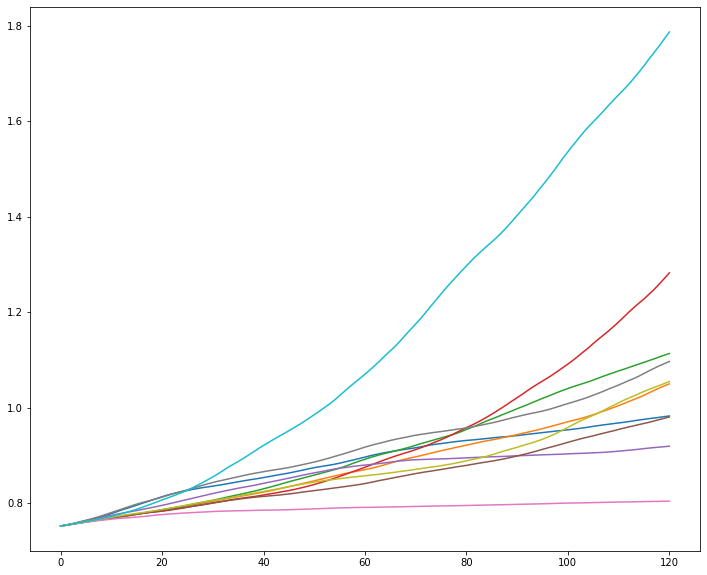

In [20]:
av_cash.plot(legend = False, figsize = (12,10))

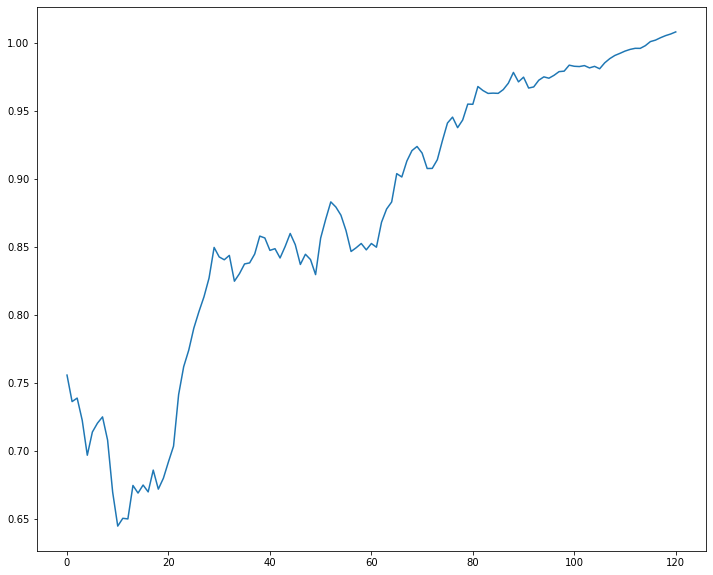

In [21]:
av_zc_bonds.plot(legend = False, figsize = (12,10))

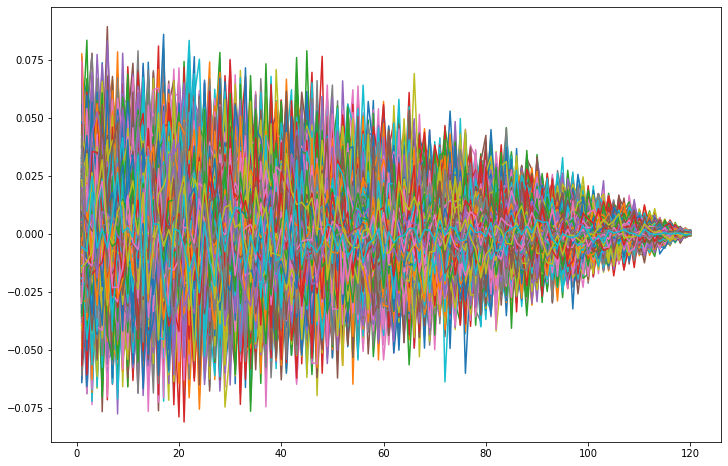

In [25]:
(av_cash/liabilities).pct_change().plot(legend = False, figsize = (12,8))

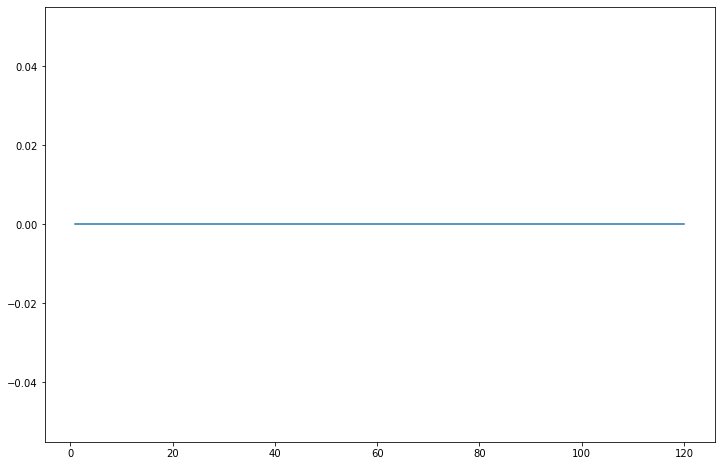

In [26]:
(av_zc_bonds/liabilities).pct_change().plot(legend = False, figsize = (12,8))

In [24]:
a_0 = 0.75
rates, bond_prices = cir(n_scenarios=10000, r_0 = 0.03 , b=0.03)
liabilities = bond_prices
zc_0 = erk.pv(zcbond_10, 0.03)
n_bonds = a_0/zc_0
av_zc_bonds = n_bonds*bond_prices
av_cash = a_0*(rates/12+1).cumprod()

In [ ]:
tfr_cash = av_cash.iloc[-1]/liabilities.iloc[-1]

In [ ]:
tfr_zc_bonds = av_zc_bonds.iloc[-1]/liabilities.iloc[-1]

In [ ]:
ax = tfr_cash.plot.hist(label = 'Cash', figsize = (12,8), bins = 100, legend = True)
tfr_zc_bonds.plot.hist(ax = ax, label = 'ZC bonds', figsize = (12,8), bins = 100, legend = True, secondary_y = True)
